<a href="https://colab.research.google.com/github/thaivo02/Sentiment-analysis/blob/main/Sentiment_analysis_to_predict_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download files

In [33]:
!pip install nltk
!pip install underthesea
!pip install transformers torch
!pip install SentencePiece

In [34]:
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt

--2024-06-29 18:15:20--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords.txt.1’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0s      

2024-06-29 18:15:20 (114 MB/s) - ‘vietnamese-stopwords.txt.1’ saved [20475/20475]



In [35]:
!wget -O mask.png "https://media.istockphoto.com/id/951462426/vi/vec-to/b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c.jpg?s=612x612&w=0&k=20&c=uvagMnaVackcfH5TN7wvuO8-Ldn-XkvkqWgc5MSANg8="

--2024-06-29 18:15:20--  https://media.istockphoto.com/id/951462426/vi/vec-to/b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c-b%C3%B3ng-b%E1%BA%A7u-d%E1%BB%A5c.jpg?s=612x612&w=0&k=20&c=uvagMnaVackcfH5TN7wvuO8-Ldn-XkvkqWgc5MSANg8=
Resolving media.istockphoto.com (media.istockphoto.com)... 18.164.124.36, 18.164.124.96, 18.164.124.125, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|18.164.124.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32161 (31K) [image/jpeg]
Saving to: ‘mask.png’

mask.png            100%[===================>]  31.41K  --.-KB/s    in 0.008s  

2024-06-29 18:15:20 (3.94 MB/s) - ‘mask.png’ saved [32161/32161]



# Import libraries

In [136]:
import nltk
import math
import string
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import underthesea
from underthesea import word_tokenize
from underthesea import text_normalize
from datetime import datetime
import timeit
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from google.colab import files
import os

In [37]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [38]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Prepare data

In [39]:
company_list = ['API', 'AGG', 'BID', 'FPT', 'VCB', 'ACV', 'OIL', 'ABB', 'ABC']
company_focused = ['FPT', 'OIL', 'VCB', 'API']

company_list.sort()
company_focused.sort()

vn30 = ['ACB','BCM','BID','BVH','CTG','FPT','GAS','GVR','HDB','HPG']
hnx30 = ['BVS','CAP','CEO','DHT','DTD','DVM','DXP','HLD','HUT','IDC']
hose = ['AAA','AAM','ABR','ABS','ABT','ACB','ACG','ACL', 'ADG','ADS']
hnx = ['AAV','ADC','ALT','AMC','AME','AMV','API','APS','ARM','ATS']

In [137]:
choice = input("Nhập data hay lấy thêm data ?\n 1: Nhập \n 2: Lấy \n")
if choice.lower() == "nhập" or choice == "1":
    choice = 1
else :
    choice = 2

Nhập data hay lấy thêm data ?
 1: Nhập 
 2: Lấy 
2


In [140]:
news_site = input("Chọn trang để phân tích dữ liệu: \n 1: CafeF \n 2: VietStock \n")
if news_site.lower() == "cafef" or news_site == "1":
    news_site = "cafef"
elif news_site.lower() == "vietstock" or news_site == "2":
    news_site = "vietstock"

Chọn trang để phân tích dữ liệu: 
 1: CafeF 
 2: VietStock 
1


## Import data from CSV

In [105]:
if choice == 1 and news_site.lower() == "cafef":
    cafef_news = pd.read_csv('/content/cafef.csv')
    cafef_news = cafef_news.to_dict('records')
    imported_news =cafef_news
elif choice == 1 and news_site.lower() == "vietstock":
    vietstock_news = pd.read_csv('/content/vietstock.csv')
    vietstock_news = vietstock_news.to_dict('records')
    imported_news = vietstock_news

In [106]:
company_news = {}

for record in imported_news:
    company_name = record['Company']
    news = record['News']
    content = record['Content']
    link = record['Link']
    price = record['Price']
    timeline = record['Timeline']
    if company_name not in company_news:
        company_news[company_name] = {}
        company_news[company_name]['news'] = [news]
        company_news[company_name]['content'] = [content]
        company_news[company_name]['link'] = [link]
        company_news[company_name]['price'] = [price]
        company_news[company_name]['timeline'] = [timeline]
    else:
        company_news[company_name]['news'].append(news)
        company_news[company_name]['content'].append(content)
        company_news[company_name]['link'].append(link)
        company_news[company_name]['price'].append(price)
        company_news[company_name]['timeline'].append(timeline)

In [109]:
for company in company_list:
    print(f"{company}: {company_news[company]['news']}")
    print(f"Price: {(company_news[company]['price'])}")
    print(f"Number of price: {len(company_news[company]['price'])}")
    print(f"Time line: {company_news[company]['timeline']}")
    print(f"Number of news: {len(company_news[company]['news'])}")

ABB: ['Ngân hàng tìm hướng hút CASA', 'Cổ phiếu ngân hàng phân hóa', 'International Finance Corporation không còn là cổ đông lớn', 'CBTT vv phê duyệt Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ Ngân hàng TMCP An Bình', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', '[Infographics] Toàn cảnh kết quả kinh doanh ngân hàng quý 1/2024', 'Thoái toàn bộ gần 85 triệu cp, IFC không còn là cổ đông của ABBank', 'Khối ngoại bán thỏa thuận gần 85 triệu cp ABB, cao hơn 22% thị giá', 'Gần 69 triệu cp ABB khớp lệnh kỷ lục phiên 21/05', 'Tín dụng quý 2 sẽ khởi sắc?', 'Đâu là đỉnh của nợ xấu?', 'Lợi nhuận ngân hàng quý 1 giảm phụ thuộc vào tín dụng', 'Chênh lệch bình quân giữa lãi suất cho vay và huy động từ 2-4%/năm', 'Cổ phiếu ngân hàng “hụt hơi”', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024', 'Kế hoạch lợi nhuận tăng tr

## Call API to get data

In [141]:
fromDate = '01/01/2024'
toDate = '27/06/2024'

### Crawl data from CafeF

In [142]:
headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0"}

In [143]:
cafef_news = {}
cafef_base_url = "https://s.cafef.vn/"
cafef_news_url = f"{cafef_base_url}Ajax/Events_RelatedNews_New.aspx"

In [145]:
if choice == 2 and news_site.lower() == "cafef":

    for company in company_list:
        index = 1
        finished = False
        cafef_news[company] = {}
        cafef_news[company]['news'] = []
        cafef_news[company]['timeline'] = []
        cafef_news[company]['content'] = []
        cafef_news[company]['link'] = []
        while not finished:
            url = f"{cafef_news_url}?symbol={company}&floorID=0&configID=0&PageIndex={index}&PageSize=30&Type=2"
            response = requests.get(url, headers = headers)
            if response.status_code == 200:
                news_body = BeautifulSoup(response.content, "html.parser")
                titles = news_body.find_all("a", class_="docnhanhTitle")
                titles = [title.text.strip().split(": ")[-1] for title in titles]
                links = news_body.find_all("a")
                links = [link['href'] for link in links]
                if len(cafef_news[company]['link']) == 0:
                    cafef_news[company]['link'] = links
                else:
                    cafef_news[company]['link'].extend(links)
                for link in links:
                    news_url = f"{cafef_base_url}{link}"
                    print(news_url)
                    news_response = requests.get(news_url, headers = headers)
                    if news_response.status_code == 200:
                        content_body = BeautifulSoup(news_response.content, "html.parser")
                        contents = content_body.find_all("div", {"id": "newscontent"})
                        contents = [content.text.strip() for content in contents]
                        if len(cafef_news[company]['content']) == 0:
                            cafef_news[company]['content'] = contents
                        else:
                            cafef_news[company]['content'].extend(contents)
                timeline = news_body.find_all("span", class_="timeTitle")
                timeline = [time.text.strip().split(' ')[0] for time in timeline]
                if len(cafef_news[company]['news']) == 0:
                    cafef_news[company]['news'] = titles
                    cafef_news[company]['timeline'] = timeline
                else:
                    cafef_news[company]['news'].extend(titles)
                    cafef_news[company]['timeline'].extend(timeline)
                print(f"Fetched data for {company} - page: {index}")
            else:
                print(f"Failed to fetch data for {company}")
            if datetime.strptime(timeline[-1], "%d/%m/%Y") <= datetime.strptime(fromDate, "%d/%m/%Y"):
                finished = True
            else:
                index += 1

https://s.cafef.vn//abb-2002215/shn-nghi-quyet-hdqt-chap-thuan-phuon-an-nhan-cap-tin-dung-cua-abbank.chn
https://s.cafef.vn//abb-1999412/abb-international-finance-corporation-khong-con-la-co-dong-lon.chn
https://s.cafef.vn//abb-1998383/abb-cap-the-tin-dung-cho-nguoi-noi-bo-va-nguoi-co-lien-quan-cua-nguoi-noi-bo.chn
https://s.cafef.vn//abb-1996209/lo-dien-co-dong-ban-82-co-phan-abbank-trong-phien-225.chn
https://s.cafef.vn//abb-1983010/quy-i2024-abbank-lai-178-ty-dong-thu-hoach-lon-tu-ngan-hang-so.chn
https://s.cafef.vn//abb-1980783/abb-cap-the-tin-dung-cho-nguoi-co-lien-quan-cua-nguoi-noi-bo.chn
https://s.cafef.vn//abb-1973831/ceo-abbank-nam-2024-se-la-mot-su-khoi-dau-manh-me-cho-chien-luoc-chuyen-doi-o-abbank.chn
https://s.cafef.vn//abb-1974716/abb-bo-nhiem-ong-nguyen-hong-quang-giu-chuc-thanh-vien-bks-tu-05042024.chn
https://s.cafef.vn//abb-1974530/abb-nghi-quyet-dai-hoi-dong-co-dong-thuong-nien-nam-2024.chn
https://s.cafef.vn//abb-1971722/dhdcd-abbank-chu-tich-hdqt-noi-gi-ve-viec-gi

In [146]:
if choice == 2 and news_site.lower() == "cafef":

    for company in company_list:
        company_date = list(cafef_news[company]['timeline'])
        cafef_news[company]['price'] = []
        startDate = company_date[-1]
        startDate = datetime.strptime(startDate, "%d/%m/%Y")
        startDate = startDate.strftime("%m/%d/%Y")
        endDate = company_date[0]
        endDate = datetime.strptime(endDate, "%d/%m/%Y")
        endDate = endDate.strftime("%m/%d/%Y")
        finished = False
        index = 1
        while not finished:
            url = f"https://s.cafef.vn/Ajax/PageNew/DataHistory/PriceHistory.ashx?Symbol={company}&StartDate={startDate}&EndDate={endDate}&PageIndex={index}"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                if 'Data' in data:
                    data = data['Data']['Data']
                    for date in company_date:
                        for item in data:
                            if item['Ngay'] == date:
                                cafef_news[company]['price'].append(float(item['GiaDongCua']))
            else:
                print(f"Failed to fetch price data for {company}")
            if len(data) == 0:
                finished = True
            elif datetime.strptime(data[-1]['Ngay'], "%d/%m/%Y") <= datetime.strptime(company_date[-1], "%d/%m/%Y"):
                finished = True
            else:
                index += 1
            price_len = len(cafef_news[company]['price'])
            date_len = len(company_date)
            if price_len < date_len:
                last_price = cafef_news[company]['price'][-1] if price_len > 0 else 0
                cafef_news[company]['price'].extend([last_price] * (date_len - price_len))

In [147]:
for company in company_list:
    print(f"{company}: {cafef_news[company]['news']}")
    print(f"Price: {(cafef_news[company]['price'])}")
    print(f"Number of price: {len(cafef_news[company]['price'])}")
    print(f"Time line: {cafef_news[company]['timeline']}")
    print(f"Number of news: {len(cafef_news[company]['news'])}")

ABB: ['Nghị quyết HĐQT chấp thuận phươn án nhận cấp tín dụng của ABBank', 'International Finance Corporation không còn là cổ đông lớn', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', 'Lộ diện cổ đông bán 8,2% cổ phần ABBank trong phiên 22/5', 'ABBank lãi 178 tỷ đồng, thu hoạch lớn từ ngân hàng số', 'Cấp thẻ tín dụng cho người có liên quan của người nội bộ', 'Năm 2024 sẽ là một sự khởi đầu mạnh mẽ cho chiến lược chuyển đổi ở ABBank', 'Bổ nhiệm ông Nguyễn Hồng Quang giữ chức Thành viên BKS từ 05.04.2024', 'Nghị quyết Đại hội đồng cổ đông thường niên năm 2024', 'Chủ tịch HĐQT nói gì về việc giá cổ phiếu giảm, kế hoạch niêm yết trên HoSE?', 'Tài liệu họp Đại hội đồng cổ đông', 'Tài liệu họp Đại hội đồng cổ đông', 'Tài liệu tổ chức ĐHCĐ thường niên năm 2024', 'Giao dịch Phát hành thẻ tín dụng cho người nội bộ', 'ABBank chuẩn bị họp cổ đông 2024, đặt mục tiêu lợi nhuận 1.000 tỷ đồng, tín dụng tăng trưởng 13%', 'Giải trình liên quan đến Báo cáo tài chính năm 2023'

In [148]:
if choice == 2 and news_site.lower() == "cafef":

    restructured_data = []
    for company, info in cafef_news.items():
        for news, content, link, price, timeline in zip(info['news'], info['content'], info['link'], info['price'], info['timeline']):
            restructured_data.append({'Company': company, 'News': news, 'Content': content, 'Link': link, 'Price': price, 'Timeline': timeline})

    df = pd.DataFrame(restructured_data)
    df.to_csv('cafef.csv', index=False)

### Crawl data from VietStock

In [48]:
headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0",
    "Content-Type": "application/x-www-form-urlencoded"
}

In [49]:
url = 'https://finance.vietstock.vn/View/PagingNewsContent'

In [50]:
vietstock_news = {}
vietstock_base_url = "https://finance.vietstock.vn/"
vietstock_news_url = f"{vietstock_base_url}View/PagingNewsContent"

In [149]:
if choice == 2 and news_site.lower() == "vietstock":

    for company in company_list:
        index = 1
        max_index = 2
        finished = False
        vietstock_news[company] = {}
        vietstock_news[company]['news'] = []
        vietstock_news[company]['timeline'] = []
        vietstock_news[company]['content'] = []
        vietstock_news[company]['link'] = []
        while not finished:
            data = {
                'view': '1',
                'code': company,
                'type': '1',
                'fromDate': fromDate,
                'toDate': toDate,
                'channelID': '-1',
                'page': index,
                'pageSize': '20'
            }
            url = vietstock_news_url
            response = requests.post(url, headers = headers, data = data)
            if response.status_code == 200:
                news_body = BeautifulSoup(response.content, "html.parser")
                total_pages = news_body.find_all("div", class_="m-b pull-left")
                if (len(total_pages) > 0):
                    total_pages = int(total_pages[-1].text.split(' ')[-1])
                    max_index = total_pages
                titles = news_body.find_all("a", class_="text-link news-link")
                titles = [title.text.strip().split(": ")[-1] for title in titles]
                links = news_body.find_all("a", class_="text-link news-link")
                links = [link['href'] for link in links]
                if len(vietstock_news[company]['link']) == 0:
                    vietstock_news[company]['link'] = links
                else:
                    vietstock_news[company]['link'].extend(links)
                for link in links:
                    news_url = f"https:{link}"
                    print(news_url)
                    news_response = requests.get(news_url, headers = headers)
                    if news_response.status_code == 200:
                        content_body = BeautifulSoup(news_response.content, "html.parser")
                        contents = content_body.find_all("div", {"id": "vst_detail"})
                        contents = [content.text.strip() for content in contents]
                        if len(vietstock_news[company]['content']) == 0:
                            vietstock_news[company]['content'] = contents
                        else:
                            vietstock_news[company]['content'].extend(contents)
                timeline = news_body.find_all("td", class_="col-date")
                timeline = [time.text.strip().split(' ')[0] for time in timeline]
                if len(vietstock_news[company]['news']) == 0:
                    vietstock_news[company]['news'] = titles
                    vietstock_news[company]['timeline'] = timeline
                else:
                    vietstock_news[company]['news'].extend(titles)
                    vietstock_news[company]['timeline'].extend(timeline)
                print(f"Fetched data for {company} - page: {index}")
            else:
                print(f"Failed to fetch data for {company}")
            if index == max_index:
                finished = True
            else:
                index += 1

In [116]:
if choice == 2 and news_site.lower() == "vietstock":

    for company in company_list:
        company_date = list(vietstock_news[company]['timeline'])
        vietstock_news[company]['price'] = []
        startDate = company_date[-1]
        startDate = datetime.strptime(startDate, "%d/%m/%Y")
        startDate = startDate.strftime("%m/%d/%Y")
        endDate = company_date[0]
        endDate = datetime.strptime(endDate, "%d/%m/%Y")
        endDate = endDate.strftime("%m/%d/%Y")
        finished = False
        index = 1
        while not finished:
            url = f"https://s.cafef.vn/Ajax/PageNew/DataHistory/PriceHistory.ashx?Symbol={company}&StartDate={startDate}&EndDate={endDate}&PageIndex={index}"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                if 'Data' in data:
                    data = data['Data']['Data']
                    for date in company_date:
                        for item in data:
                            if item['Ngay'] == date:
                                vietstock_news[company]['price'].append(float(item['GiaDongCua']))
            else:
                print(f"Failed to fetch price data for {company}")
            if len(data) == 0:
                finished = True
            elif datetime.strptime(data[-1]['Ngay'], "%d/%m/%Y") <= datetime.strptime(company_date[-1], "%d/%m/%Y"):
                finished = True
            else:
                index += 1
            price_len = len(vietstock_news[company]['price'])
            date_len = len(company_date)
            if price_len < date_len:
                last_price = vietstock_news[company]['price'][-1] if price_len > 0 else 0
                vietstock_news[company]['price'].extend([last_price] * (date_len - price_len))

In [53]:
for company in company_list:
    print(f"{company}: {vietstock_news[company]['news']}")
    print(f"Price: {(vietstock_news[company]['price'])}")
    print(f"Number of price: {len(vietstock_news[company]['price'])}")
    print(f"Time line: {vietstock_news[company]['timeline']}")
    print(f"Number of news: {len(vietstock_news[company]['news'])}")

ABB: ['Ngân hàng tìm hướng hút CASA', 'Cổ phiếu ngân hàng phân hóa', 'International Finance Corporation không còn là cổ đông lớn', 'CBTT vv phê duyệt Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ Ngân hàng TMCP An Bình', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', '[Infographics] Toàn cảnh kết quả kinh doanh ngân hàng quý 1/2024', 'Thoái toàn bộ gần 85 triệu cp, IFC không còn là cổ đông của ABBank', 'Khối ngoại bán thỏa thuận gần 85 triệu cp ABB, cao hơn 22% thị giá', 'Gần 69 triệu cp ABB khớp lệnh kỷ lục phiên 21/05', 'Tín dụng quý 2 sẽ khởi sắc?', 'Đâu là đỉnh của nợ xấu?', 'Lợi nhuận ngân hàng quý 1 giảm phụ thuộc vào tín dụng', 'Chênh lệch bình quân giữa lãi suất cho vay và huy động từ 2-4%/năm', 'Cổ phiếu ngân hàng “hụt hơi”', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024', 'Kế hoạch lợi nhuận tăng tr

In [117]:
if choice == 2 and news_site.lower() == "vietstock":
    restructured_data = []
    for company, info in vietstock_news.items():
        for news, content, link, price, timeline in zip(info['news'], info['content'], info['link'], info['price'], info['timeline']):
            restructured_data.append({'Company': company, 'News': news, 'Content': content, 'Link': link, 'Price': price, 'Timeline': timeline})

    df = pd.DataFrame(restructured_data)
    df.to_csv('vietstock.csv', index=False)

## Preprocess data

In [118]:
if choice == 2 and news_site.lower() == "cafef":
    company_news = cafef_news
elif choice == 2 and news_site.lower() == "vietstock":
    company_news = vietstock_news

### Tokenize Vietnamese

In [56]:
stop_words = set()
with open('vietnamese-stopwords.txt', 'r') as f:
    for line in f:
        stop_words.add(line.strip())

In [57]:
def clean_text(text):
    text = text.lower() # lowercase text

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation

    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation

    text = re.sub(r"\s+", " ", text) # reduce multiple spaces

    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)

    text = text.split(' ')

    text = [word for word in text if word not in stop_words] # remove stop words

    text = ' '.join(text)
    return text

In [128]:
for company, item in company_news.items():
    company_news[company]['tokenized_news'] = []
    for title in item['news']:
        title = clean_text(title)
        company_news[company]['tokenized_news'].append(title)

In [121]:
for company, item in company_news.items():
    company_news[company]['tokenized_content'] = []
    for title in item['content']:
        title = clean_text(title)
        company_news[company]['tokenized_content'].append(title)

In [129]:
for company in company_list:
    print(f"{company}: {company_news[company]['news']}")
    print(f"Number of news: {len(company_news[company]['news'])}")
    print(f"Tokenized news: {company_news[company]['tokenized_news']}")
    print(f"Number of tokenized_content: {len(company_news[company]['tokenized_content'])}")
    print(f"Number of tokenized_news: {len(company_news[company]['tokenized_news'])}")

ABB: ['Ngân hàng tìm hướng hút CASA', 'Cổ phiếu ngân hàng phân hóa', 'International Finance Corporation không còn là cổ đông lớn', 'CBTT vv phê duyệt Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ Ngân hàng TMCP An Bình', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', '[Infographics] Toàn cảnh kết quả kinh doanh ngân hàng quý 1/2024', 'Thoái toàn bộ gần 85 triệu cp, IFC không còn là cổ đông của ABBank', 'Khối ngoại bán thỏa thuận gần 85 triệu cp ABB, cao hơn 22% thị giá', 'Gần 69 triệu cp ABB khớp lệnh kỷ lục phiên 21/05', 'Tín dụng quý 2 sẽ khởi sắc?', 'Đâu là đỉnh của nợ xấu?', 'Lợi nhuận ngân hàng quý 1 giảm phụ thuộc vào tín dụng', 'Chênh lệch bình quân giữa lãi suất cho vay và huy động từ 2-4%/năm', 'Cổ phiếu ngân hàng “hụt hơi”', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024', 'Kế hoạch lợi nhuận tăng tr

### Plot word cloud

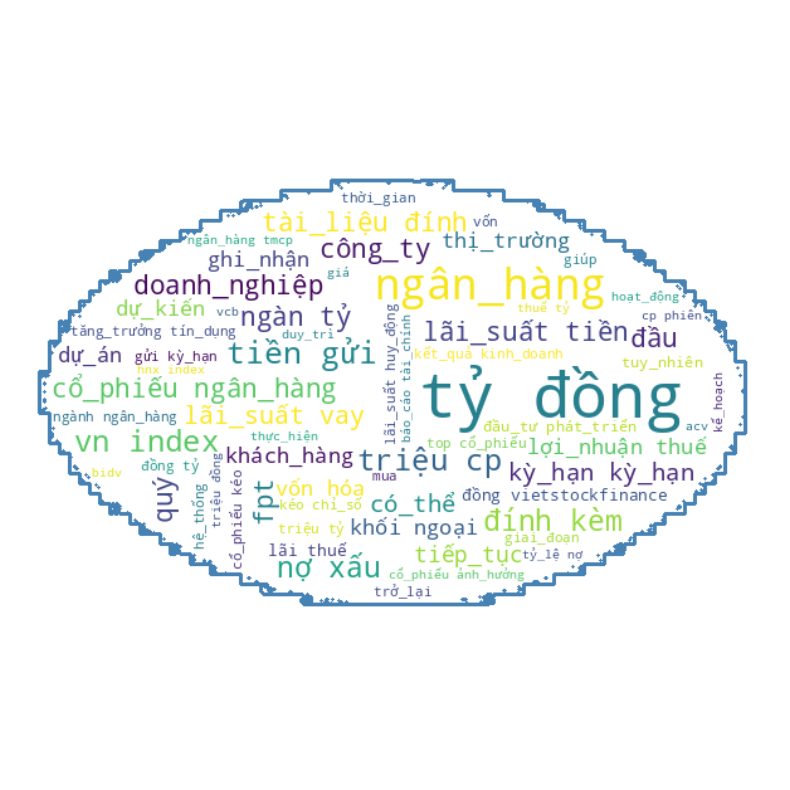

In [150]:
mask = np.array(Image.open('/content/mask.png'))

# Example data (replace with your actual data)
titles = []
for company, item in company_news.items():
    titles.extend(item['tokenized_content'])
titles = ' '.join(titles)

# Create WordCloud object with custom mask and parameters
wordcloud = WordCloud(background_color='white',
                      mask=mask,
                    #   stopwords=STOPWORDS,
                      contour_width=2,
                      contour_color='steelblue',
                    #   max_words=100,
                      max_font_size=50,
                      min_font_size=10)

# Generate word cloud
wordcloud.generate(titles)

# Plot the WordCloud image
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('word_cloud.png')
plt.show()

### Plot news length

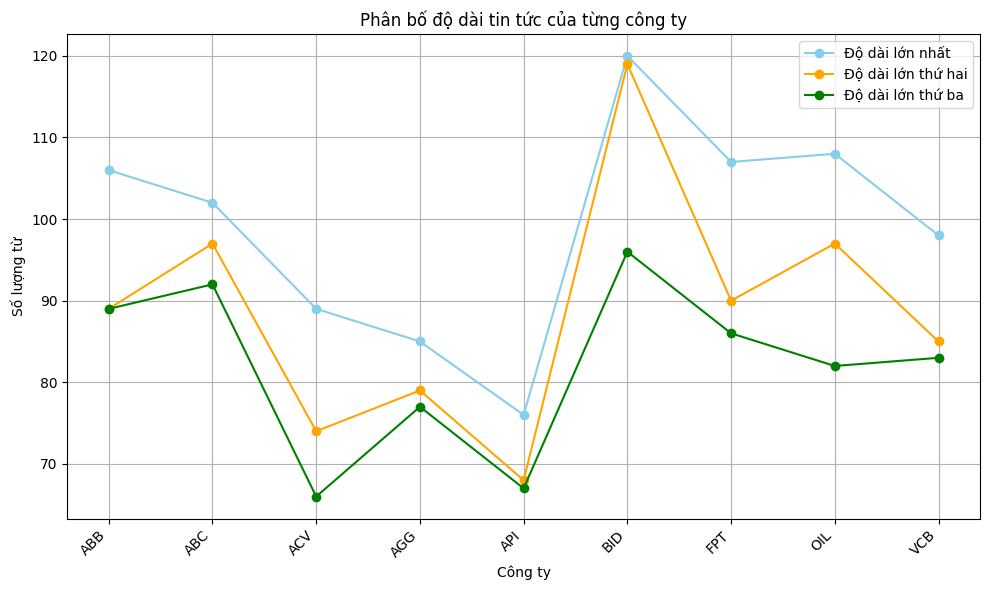

In [151]:
company_names = list(company_news.keys())
# Tạo danh sách chứa 3 độ dài dài nhất của tokenized_news cho mỗi công ty
top_lengths = []
for company in company_names:
    tokenized_news_lengths = [len(item) for item in company_news[company]['tokenized_news']]
    top_lengths.append(sorted(tokenized_news_lengths, reverse=True)[:3])

# Vẽ biểu đồ đường
plt.figure(figsize=(10, 6))

# Tạo mảng các index cho từng công ty
index = np.arange(1, len(company_names) + 1)

# Vẽ biểu đồ đường cho từng độ dài dài nhất
plt.plot(index, [max(lengths) for lengths in top_lengths], marker='o', linestyle='-', color='skyblue', label='Độ dài lớn nhất')
plt.plot(index, [sorted(lengths, reverse=True)[1] if len(lengths) > 1 else 0 for lengths in top_lengths], marker='o', linestyle='-', color='orange', label='Độ dài lớn thứ hai')
plt.plot(index, [sorted(lengths, reverse=True)[2] if len(lengths) > 2 else 0 for lengths in top_lengths], marker='o', linestyle='-', color='green', label='Độ dài lớn thứ ba')

plt.title('Phân bố độ dài tin tức của từng công ty')
plt.xlabel('Công ty')
plt.ylabel('Số lượng từ')
plt.xticks(index, company_names, rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

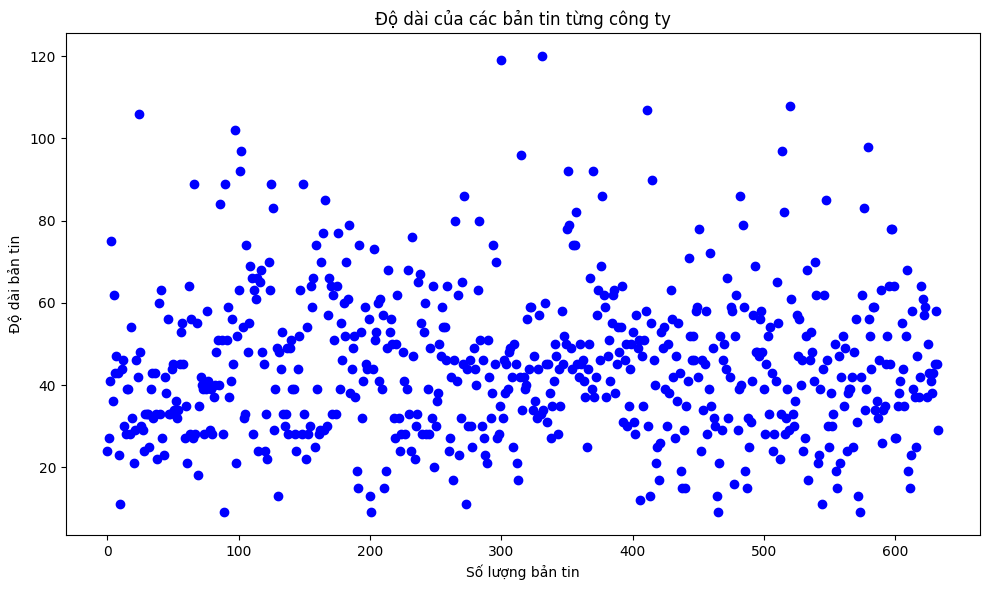

In [152]:
tokenized_news_lengths = []
company_indices = []

for company in company_news:
    for item in company_news[company]['tokenized_news']:
        tokenized_news_lengths.append(len(item))
        company_indices.append(company)

# Tạo mảng chỉ số của từng tin tức
indices = list(range(len(tokenized_news_lengths)))

# Vẽ biểu đồ scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(indices, tokenized_news_lengths, marker='o', color='b')

# Đặt nhãn cho các trục
plt.xlabel('Số lượng bản tin')
plt.ylabel('Độ dài bản tin')
plt.title('Độ dài của các bản tin từng công ty')

# Định dạng số trên trục y để hiển thị số nguyên
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

# Đặt các vị trí và nhãn trên trục x
# plt.xticks([100, 500, 1000, 2000, 4000])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [153]:
# Define a function to extract the lower bound of each range
def extract_lower_bound(s):
    match = re.match(r'(\d+)-', s)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # Return a very large number if format doesn't match

In [154]:
def extract_bounds(s):
    match = re.match(r'(\d+)-(\d+)', s)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        return None

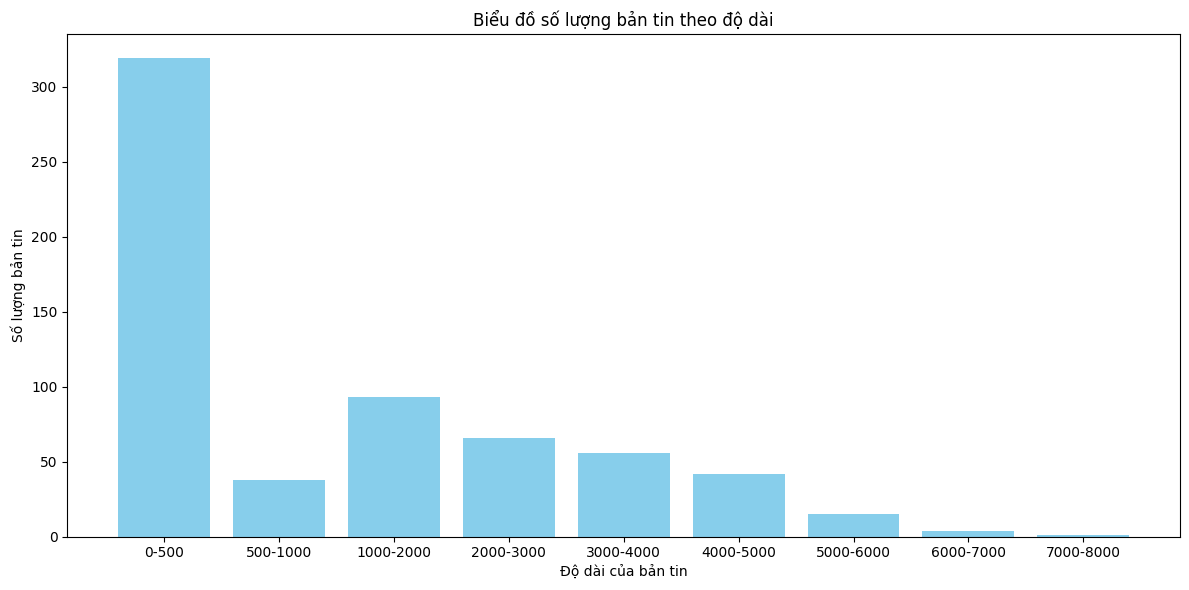

In [161]:
group_lengths = {}

for company, item in company_news.items():
    for tokenized_content in item['tokenized_content']:
        news_length = len(tokenized_content)
        if news_length in group_lengths:
            group_lengths[news_length] += 1
        else:
            group_lengths[news_length] = 1
grouped_lengths = {}
bin_size = 1000  # Kích thước của mỗi khoảng

for length, count in group_lengths.items():
    bin_start = (length // bin_size) * bin_size
    bin_end = bin_start + bin_size
    bin_label = f'{bin_start}-{bin_end}'

    if bin_label in grouped_lengths:
        grouped_lengths[bin_label] += count
    else:
        grouped_lengths[bin_label] = count

# Chuyển dữ liệu từ điển thành list để dễ dàng truy xuất và sắp xếp
lengths = list(grouped_lengths.keys())
counts = list(grouped_lengths.values())

sorted_lengths = sorted(lengths, key=extract_lower_bound)
# Combine counts and lengths into pairs
pairs = list(zip(counts, lengths))

# Sort pairs based on lengths (using the index 1 of each pair)
sorted_pairs = sorted(pairs, key=lambda x: extract_lower_bound(x[1]))
# Separate sorted counts and lengths from sorted pairs
sorted_counts = [pair[0] for pair in sorted_pairs]
sorted_lengths = [pair[1] for pair in sorted_pairs]

# Vẽ biểu đồ cột (bar chart)
plt.figure(figsize=(12, 6))
plt.bar(sorted_lengths_hai, sorted_counts_hai, color='skyblue')
plt.xlabel('Độ dài của bản tin')
plt.ylabel('Số lượng bản tin')
plt.title('Biểu đồ số lượng bản tin theo độ dài')

plt.tight_layout()
plt.savefig('news_length.png')
plt.show()

### Length of focused company

API: 31
FPT: 103
OIL: 27
VCB: 112


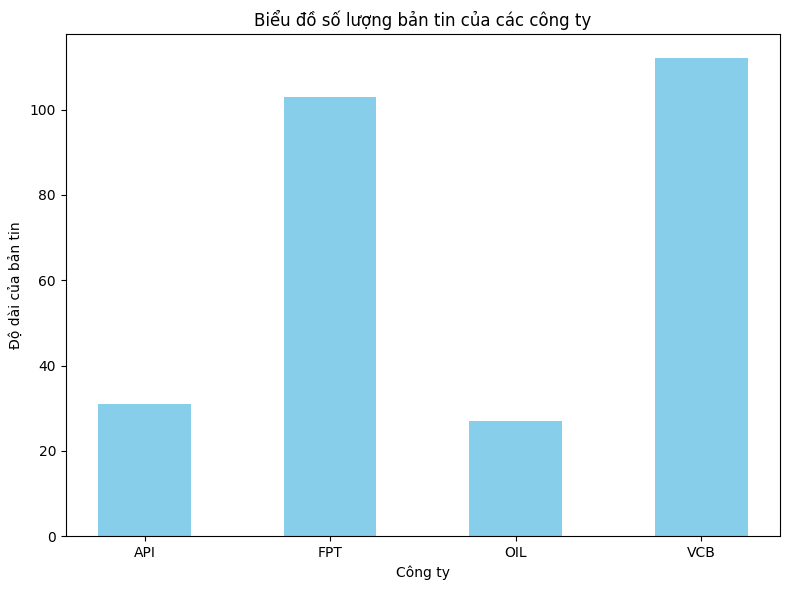

In [156]:
for company in company_focused:
    print(f"{company}: {len(company_news[company]['news'])}")

# Vẽ biểu đồ cột (bar chart)
plt.figure(figsize=(8, 6))
plt.bar(company_focused, [len(company_news[company]['news']) for company in company_focused], color='skyblue', width=0.5)
plt.xlabel('Công ty')
plt.ylabel('Độ dài của bản tin')
plt.title('Biểu đồ số lượng bản tin của các công ty')

plt.tight_layout()
plt.show()

# Use models & libraries

## Use model VADER from NLTK

### Load model

In [119]:
analyzer = SentimentIntensityAnalyzer()

In [130]:
start = timeit.default_timer()

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['tokenized_news']:
      sentiment = analyzer.polarity_scores(title)
      company_news[company]['sentiment'].append(sentiment['compound'])
      print(f"{company}: {title} - {sentiment}")

stop = timeit.default_timer()

vader_time_execution = stop - start

ABB: ngân_hàng hướng hút casa - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: cổ_phiếu ngân_hàng phân_hóa - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: international finance_corporation cổ_đông - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: cbt v phê_duyệt thẻ_tín_dụng nội_bộ liên_quan nội_bộ ngân_hàng tmcp an_bình - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: thẻ_tín_dụng nội_bộ liên_quan nội_bộ - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: infographics toàn_cảnh kết_quả kinh_doanh ngân_hàng quý 1 2024 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: thoái toàn_bộ 85 triệu cp ifc cổ_đông abank - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: khối ngoại thỏa_thuận 85 triệu cp ab 22 thị_giá - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: 69 triệu cp ab khớp lệnh kỷ_lục phiên 21 05 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
ABB: tín_dụng quý 2 khởi_sắc - {'neg': 0.0, 

In [131]:
for company, item in company_news.items():
  print(f"{company}: {item}")
  print(f"Number of news: {len(item['news'])}")
  print(f"Number of content: {len(item['content'])}")
  print(f"Number of timeline: {len(item['timeline'])}")
  print(f"Number of price: {len(item['price'])}")
  print(f"Number of sentiment: {len(item['sentiment'])}")

ABB: {'news': ['Ngân hàng tìm hướng hút CASA', 'Cổ phiếu ngân hàng phân hóa', 'International Finance Corporation không còn là cổ đông lớn', 'CBTT vv phê duyệt Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ Ngân hàng TMCP An Bình', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', '[Infographics] Toàn cảnh kết quả kinh doanh ngân hàng quý 1/2024', 'Thoái toàn bộ gần 85 triệu cp, IFC không còn là cổ đông của ABBank', 'Khối ngoại bán thỏa thuận gần 85 triệu cp ABB, cao hơn 22% thị giá', 'Gần 69 triệu cp ABB khớp lệnh kỷ lục phiên 21/05', 'Tín dụng quý 2 sẽ khởi sắc?', 'Đâu là đỉnh của nợ xấu?', 'Lợi nhuận ngân hàng quý 1 giảm phụ thuộc vào tín dụng', 'Chênh lệch bình quân giữa lãi suất cho vay và huy động từ 2-4%/năm', 'Cổ phiếu ngân hàng “hụt hơi”', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024', 'Kế hoạch lợi nhuậ

In [132]:
stock_price = []
for company, item in company_news.items():
  stock_price.append(item['price'])

In [133]:
date_time = []
for company, item in company_news.items():
  date_time.append(item['timeline'])

### Plot sentiment score

In [123]:
vader_sentiment_scores = []

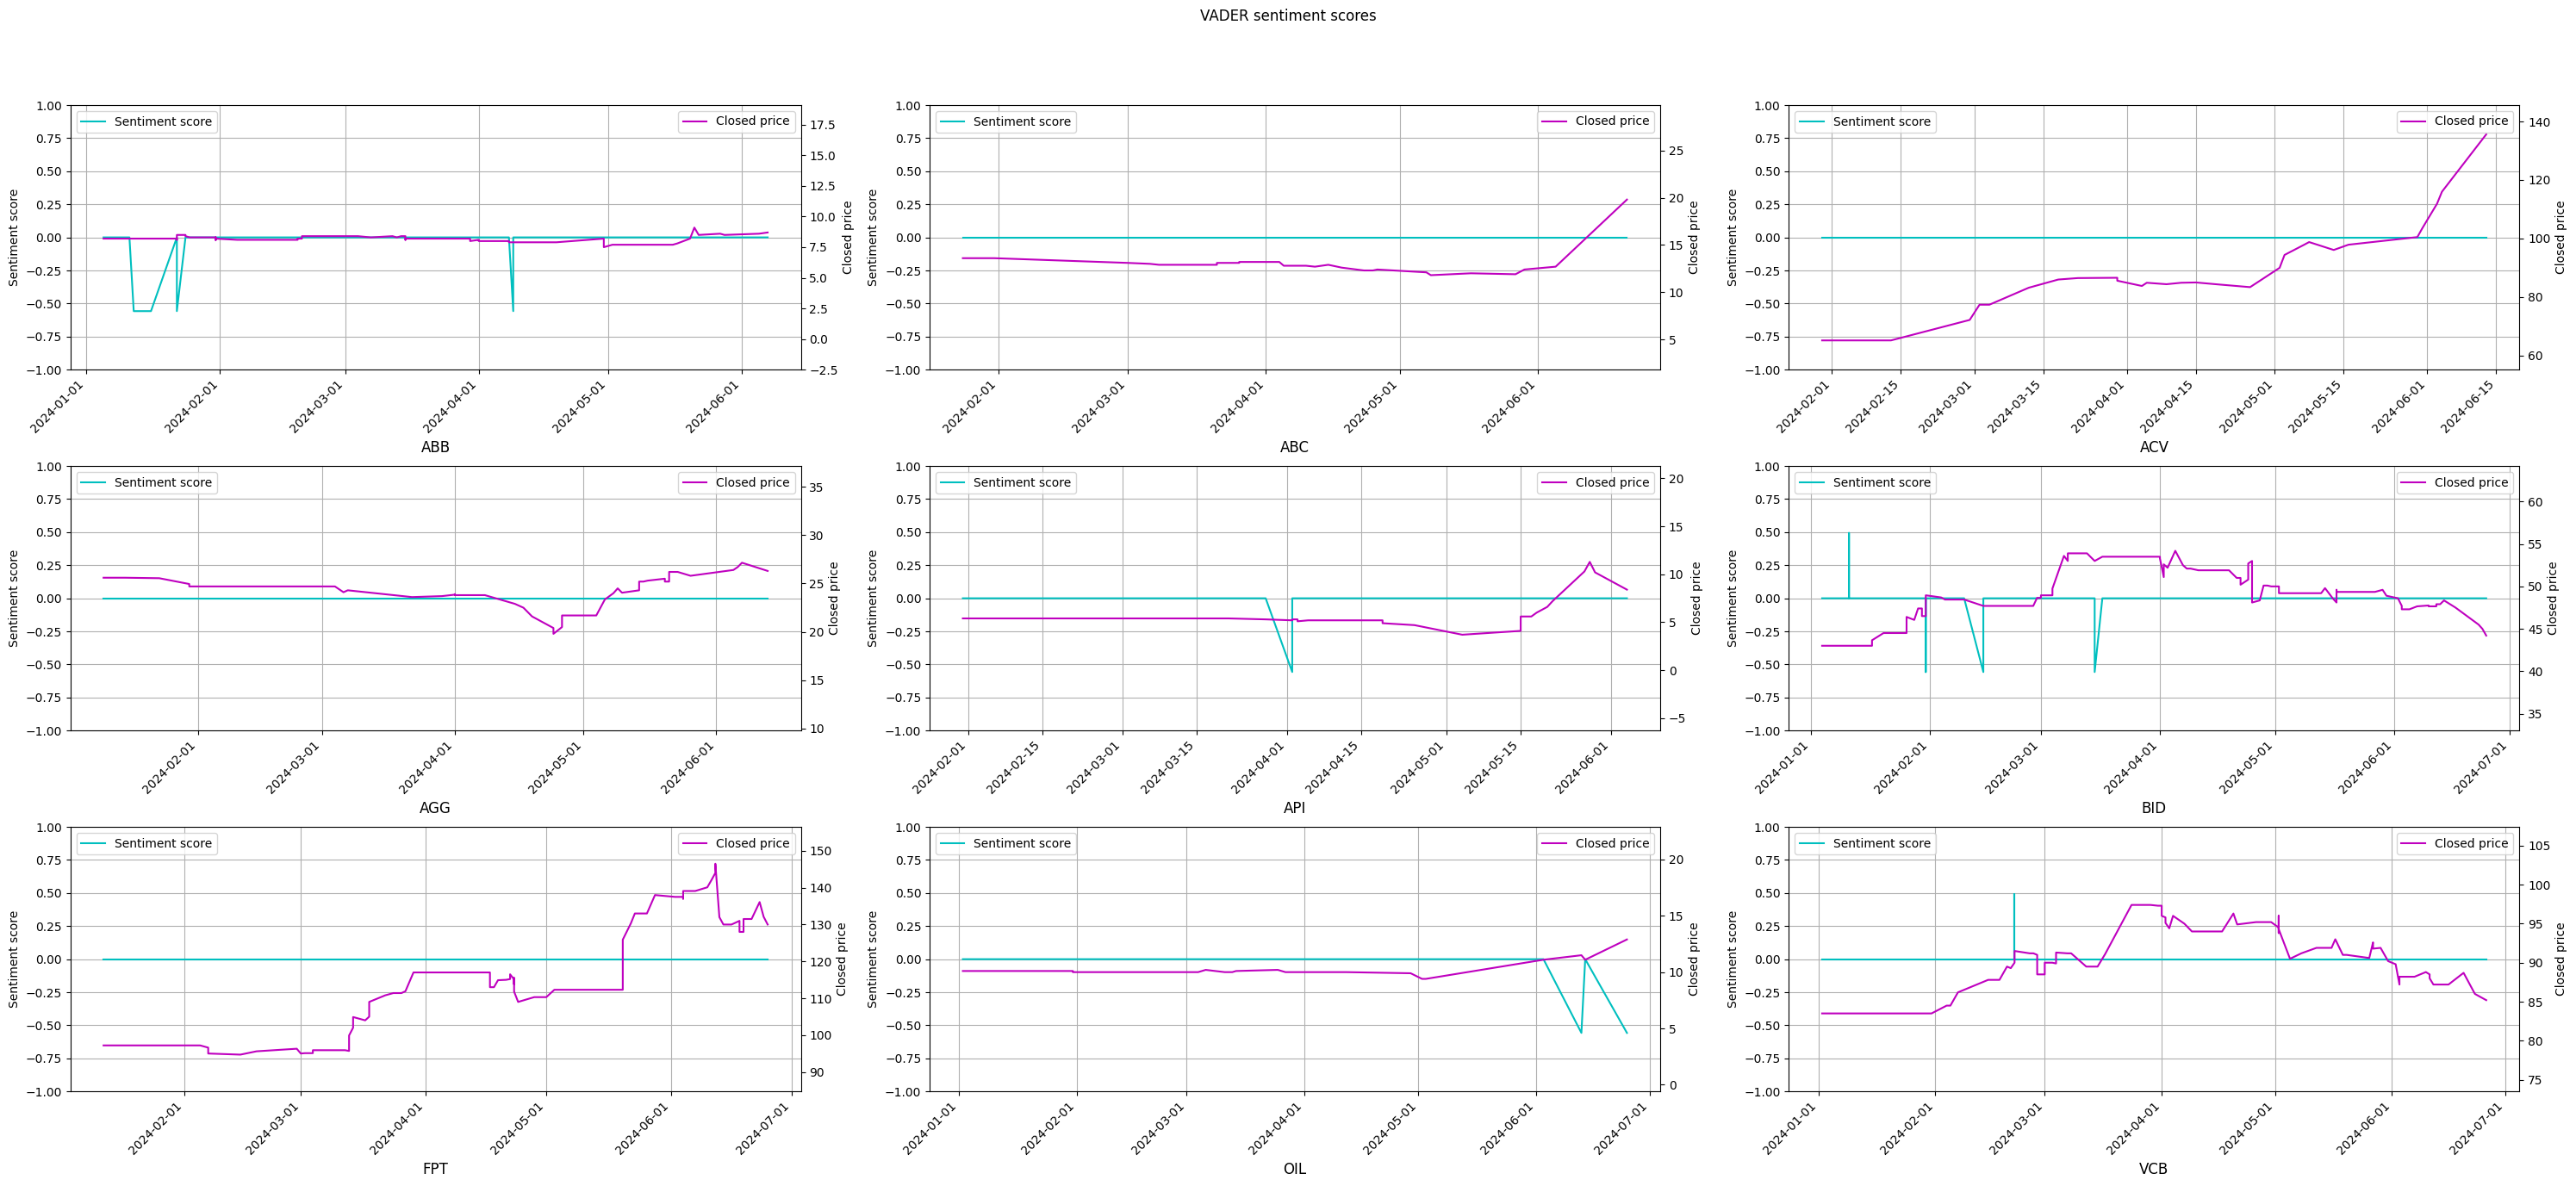

In [134]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_xlabel('Date')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    vader_sentiment_scores.append(sentiment_scores)

fig.suptitle('VADER sentiment scores')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('vader_sentiment_scores.png')
plt.show()

### Plot volatility

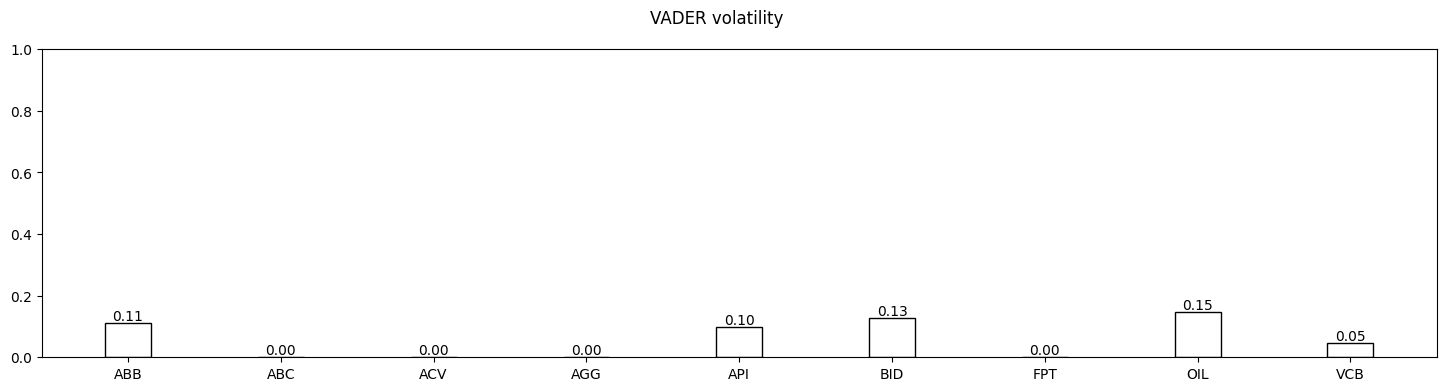

In [135]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('VADER volatility')
plt.savefig('vader_volatility.png')
plt.show()

## Use PhoBERT pretrained model from Wonrax

### Load model

In [62]:
wonrax = RobertaForSequenceClassification.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

wonrax_tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment", use_fast=False)

In [63]:
start = timeit.default_timer()

sentiments = {}

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['tokenized_news']:
        input_ids = torch.tensor([wonrax_tokenizer.encode(title)])
        with torch.no_grad():
            out = wonrax(input_ids)
            sentiments['neg'] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments['pos'] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments['neu'] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
            sentiments['compound'] = round(sentiments['pos'] - sentiments['neg'], 4)
            company_news[company]['sentiment'].append(sentiments['compound'])
            print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

phobert_time_execution = stop - start

ABB: ngân_hàng hướng hút casa - {'neg': 0.029, 'pos': 0.165, 'neu': 0.806, 'compound': 0.136}
ABB: cổ_phiếu ngân_hàng phân_hóa - {'neg': 0.977, 'pos': 0.005, 'neu': 0.018, 'compound': -0.972}
ABB: international finance_corporation cổ_đông - {'neg': 0.003, 'pos': 0.984, 'neu': 0.013, 'compound': 0.981}
ABB: cbt v phê_duyệt thẻ_tín_dụng nội_bộ liên_quan nội_bộ ngân_hàng tmcp an_bình - {'neg': 0.011, 'pos': 0.654, 'neu': 0.335, 'compound': 0.643}
ABB: thẻ_tín_dụng nội_bộ liên_quan nội_bộ - {'neg': 0.052, 'pos': 0.047, 'neu': 0.901, 'compound': -0.005}
ABB: infographics toàn_cảnh kết_quả kinh_doanh ngân_hàng quý 1 2024 - {'neg': 0.016, 'pos': 0.417, 'neu': 0.568, 'compound': 0.401}
ABB: thoái toàn_bộ 85 triệu cp ifc cổ_đông abank - {'neg': 0.908, 'pos': 0.036, 'neu': 0.056, 'compound': -0.872}
ABB: khối ngoại thỏa_thuận 85 triệu cp ab 22 thị_giá - {'neg': 0.032, 'pos': 0.059, 'neu': 0.908, 'compound': 0.027}
ABB: 69 triệu cp ab khớp lệnh kỷ_lục phiên 21 05 - {'neg': 0.024, 'pos': 0.62, 'ne

In [64]:
for company, item in company_news.items():
  print(f"{company}: {item}")
  print(f"Number of news: {len(item['news'])}")
  print(f"Number of timeline: {len(item['timeline'])}")
  print(f"Number of price: {len(item['price'])}")

ABB: {'news': ['Ngân hàng tìm hướng hút CASA', 'Cổ phiếu ngân hàng phân hóa', 'International Finance Corporation không còn là cổ đông lớn', 'CBTT vv phê duyệt Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ Ngân hàng TMCP An Bình', 'Cấp thẻ tín dụng cho người nội bộ và người có liên quan của người nội bộ', '[Infographics] Toàn cảnh kết quả kinh doanh ngân hàng quý 1/2024', 'Thoái toàn bộ gần 85 triệu cp, IFC không còn là cổ đông của ABBank', 'Khối ngoại bán thỏa thuận gần 85 triệu cp ABB, cao hơn 22% thị giá', 'Gần 69 triệu cp ABB khớp lệnh kỷ lục phiên 21/05', 'Tín dụng quý 2 sẽ khởi sắc?', 'Đâu là đỉnh của nợ xấu?', 'Lợi nhuận ngân hàng quý 1 giảm phụ thuộc vào tín dụng', 'Chênh lệch bình quân giữa lãi suất cho vay và huy động từ 2-4%/năm', 'Cổ phiếu ngân hàng “hụt hơi”', 'Báo cáo tài chính quý 1/2024', 'Báo cáo tài chính quý 1/2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024 (công ty mẹ)', 'Báo cáo tài chính Quý 1 năm 2024', 'Kế hoạch lợi nhuậ

### Plot sentiment score

In [65]:
phobert_sentiment_scores = []

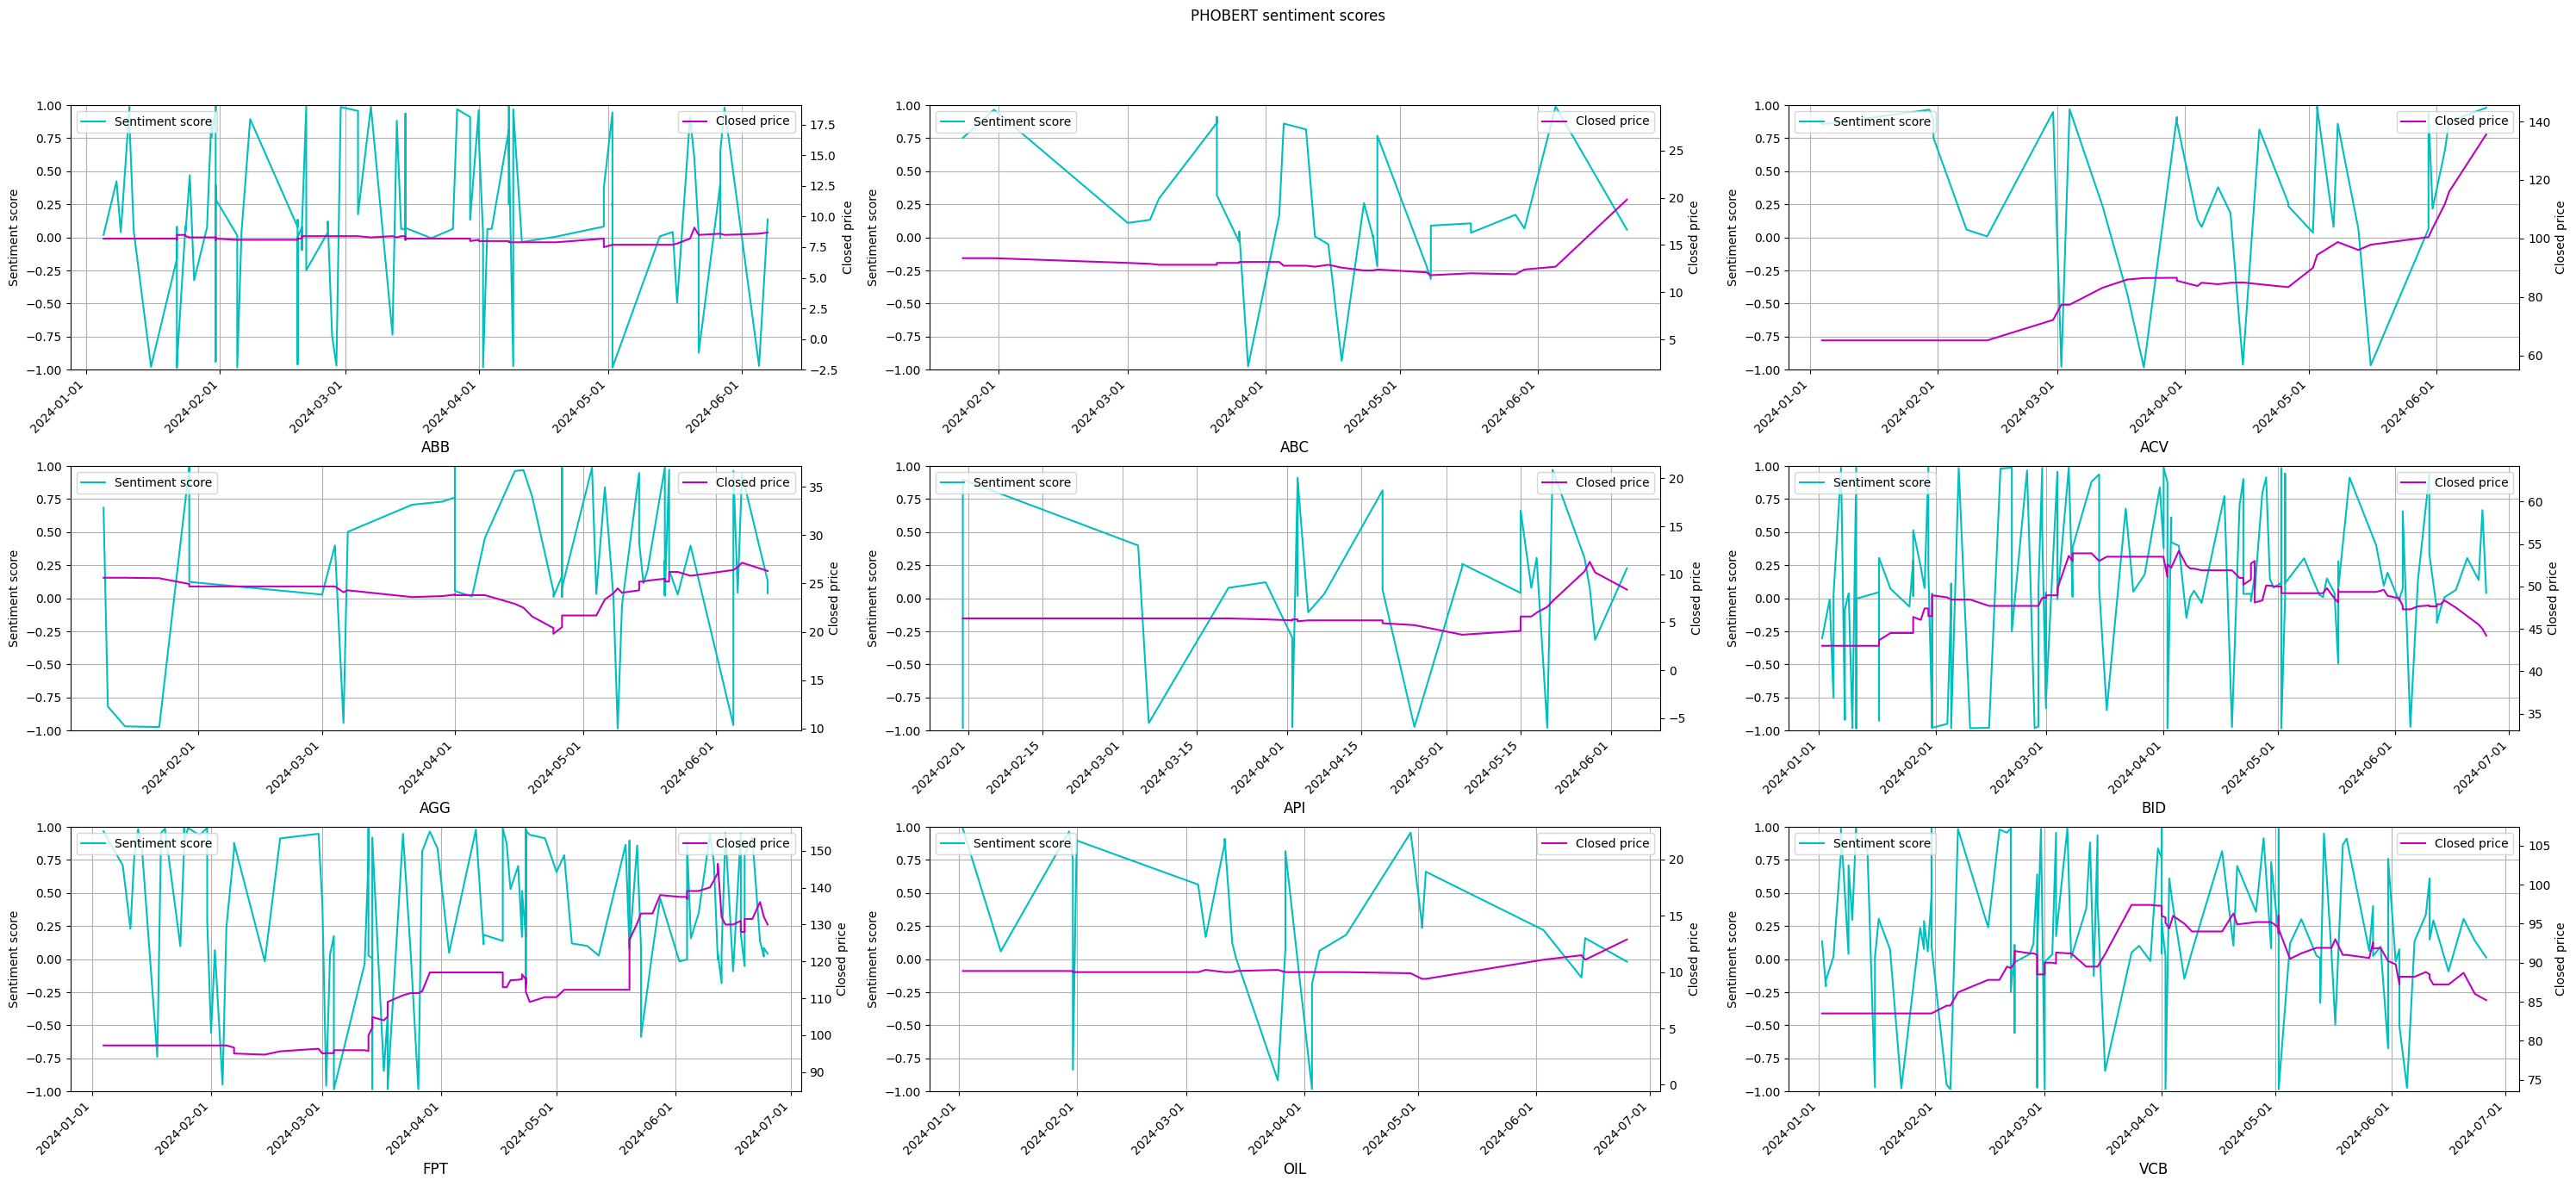

In [66]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_xlabel('Date')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    phobert_sentiment_scores.append(sentiment_scores)

fig.suptitle('PHOBERT sentiment scores')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('phobert_sentiment_scores.png')
plt.show()

### Plot volatility

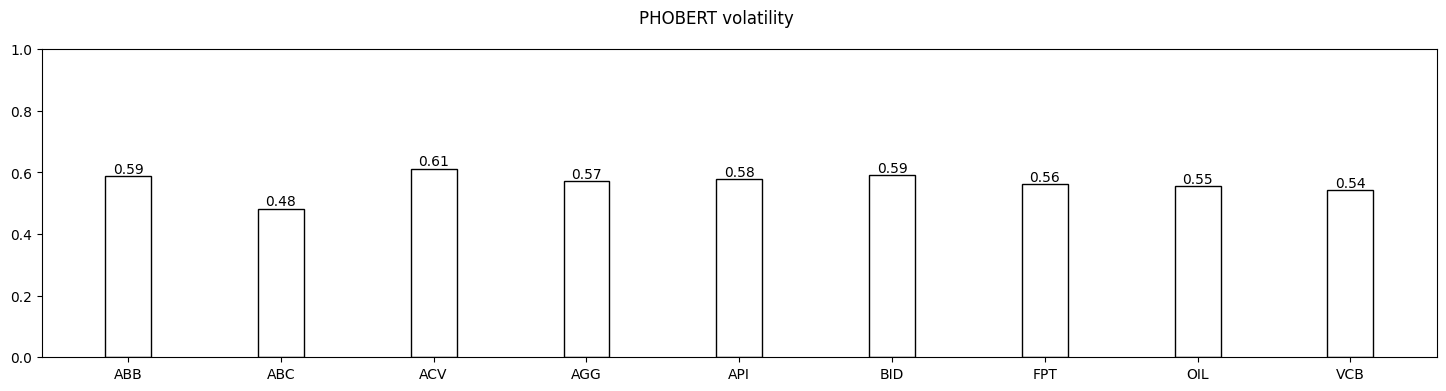

In [67]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('PHOBERT volatility')
plt.savefig('phobert_volatility.png')
plt.show()

## Use ViSoBERT

### Load model

In [68]:
uit = AutoModelForSequenceClassification.from_pretrained('uitnlp/visobert')
uit_tokenizer = AutoTokenizer.from_pretrained('uitnlp/visobert')

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

In [86]:
start = timeit.default_timer()

sentiments = {}

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['tokenized_news']:
        encoding = uit_tokenizer(title, return_tensors='pt')
        with torch.no_grad():
            output = uit(**encoding)
            sentiments['neg'] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments['pos'] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments['compound'] = round(sentiments['pos'] - sentiments['neg'], 4)
            company_news[company]['sentiment'].append(sentiments['compound'])
            print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

visobert_time_execution = stop - start

ABB: ngân_hàng hướng hút casa - {'neg': 0.511, 'pos': 0.489, 'compound': -0.022}
ABB: cổ_phiếu ngân_hàng phân_hóa - {'neg': 0.435, 'pos': 0.565, 'compound': 0.13}
ABB: international finance_corporation cổ_đông - {'neg': 0.421, 'pos': 0.579, 'compound': 0.158}
ABB: cbt v phê_duyệt thẻ_tín_dụng nội_bộ liên_quan nội_bộ ngân_hàng tmcp an_bình - {'neg': 0.524, 'pos': 0.476, 'compound': -0.048}
ABB: thẻ_tín_dụng nội_bộ liên_quan nội_bộ - {'neg': 0.482, 'pos': 0.518, 'compound': 0.036}
ABB: infographics toàn_cảnh kết_quả kinh_doanh ngân_hàng quý 1 2024 - {'neg': 0.394, 'pos': 0.606, 'compound': 0.212}
ABB: thoái toàn_bộ 85 triệu cp ifc cổ_đông abank - {'neg': 0.478, 'pos': 0.522, 'compound': 0.044}
ABB: khối ngoại thỏa_thuận 85 triệu cp ab 22 thị_giá - {'neg': 0.452, 'pos': 0.548, 'compound': 0.096}
ABB: 69 triệu cp ab khớp lệnh kỷ_lục phiên 21 05 - {'neg': 0.42, 'pos': 0.58, 'compound': 0.16}
ABB: tín_dụng quý 2 khởi_sắc - {'neg': 0.53, 'pos': 0.47, 'compound': -0.06}
ABB: đỉnh nợ xấu - {'ne

### Plot sentiment score

In [87]:
visobert_sentiment_scores = []

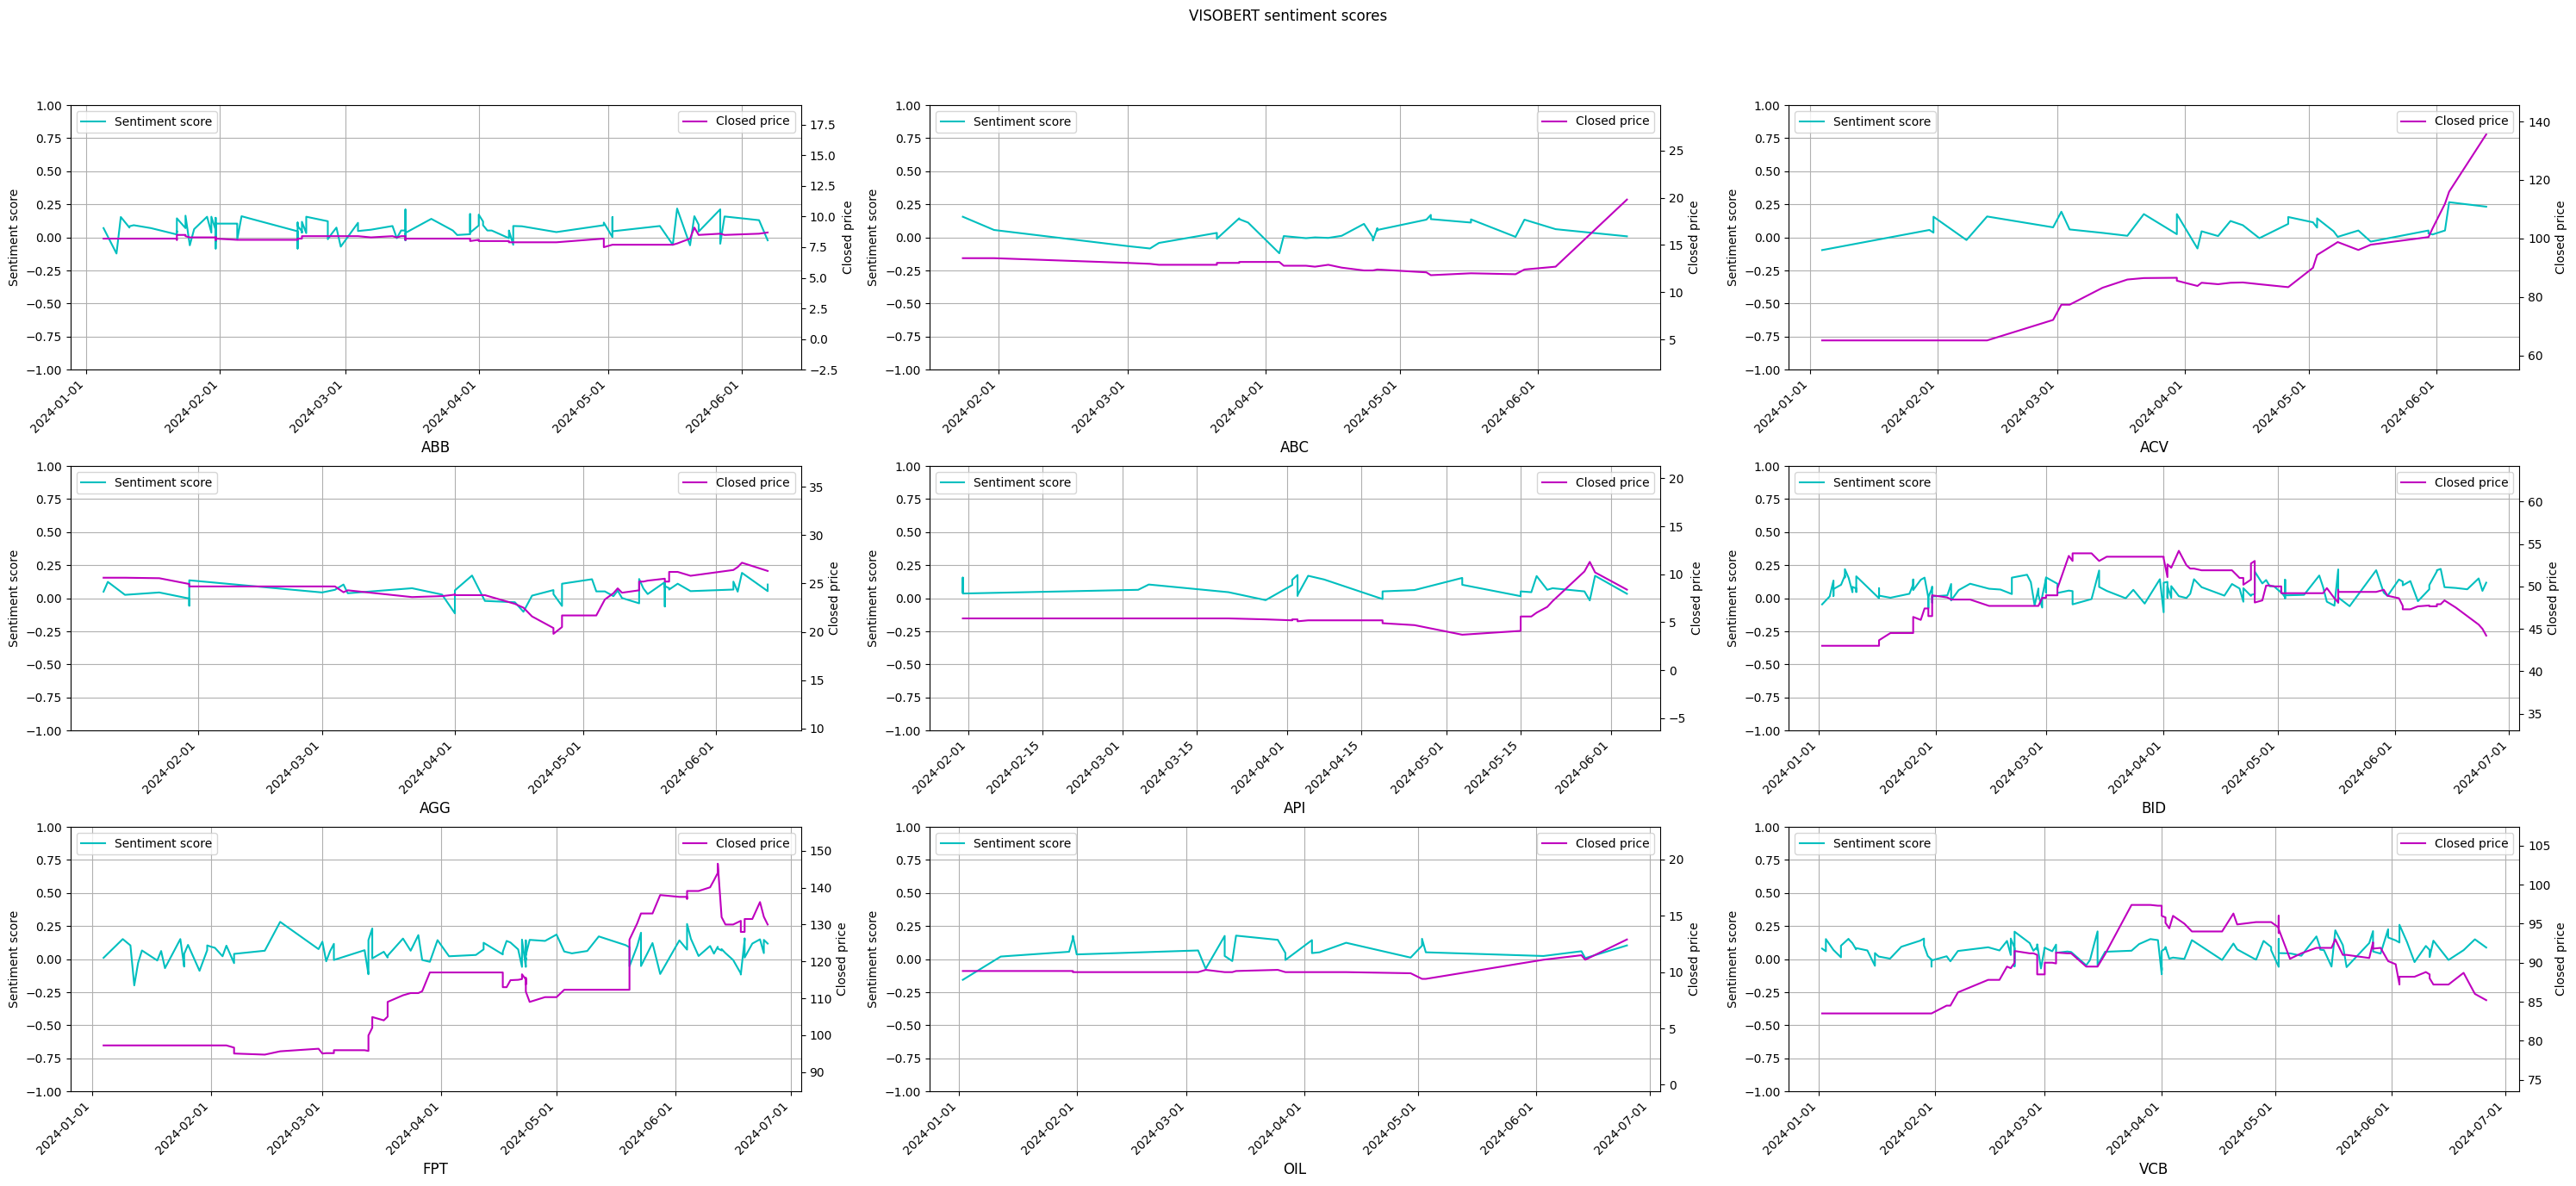

In [88]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_xlabel('Date')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    visobert_sentiment_scores.append(sentiment_scores)

fig.suptitle('VISOBERT sentiment scores')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('visobert_sentiment_scores.png')
plt.show()

### Plot volatility

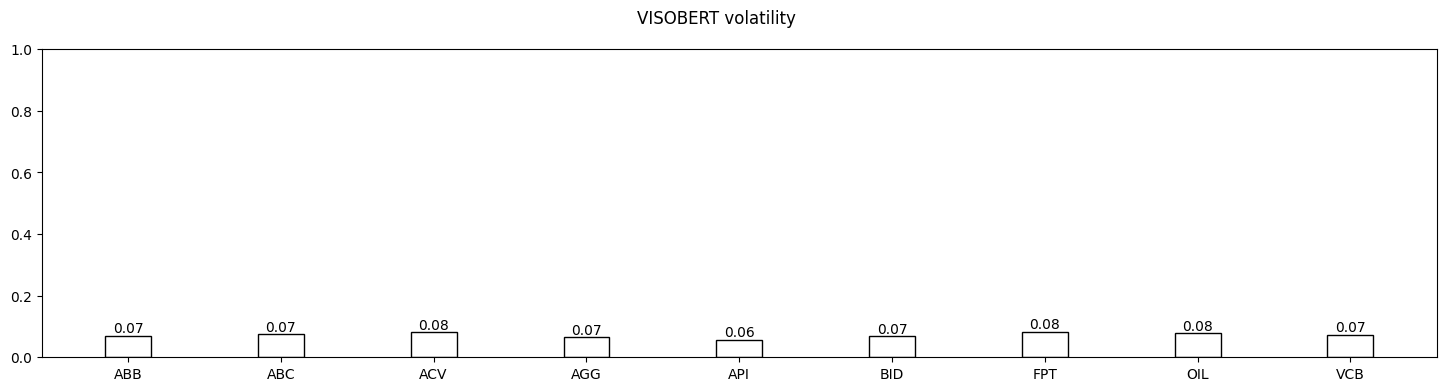

In [89]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('VISOBERT volatility')
plt.savefig('visobert_volatility.png')
plt.show()

## Compare 3 models

In [90]:
sentence = 'tươi'

wonrax_sentiment = {}

input_ids = torch.tensor([wonrax_tokenizer.encode(sentence)])
with torch.no_grad():
  out = wonrax(input_ids)
  wonrax_sentiment['neg'] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
  wonrax_sentiment['pos'] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
  wonrax_sentiment['neu'] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
  wonrax_sentiment['compound'] = round(wonrax_sentiment['pos'] - wonrax_sentiment['neg'], 4)
  print("PHOBERT", wonrax_sentiment)

uit_sentiment = {}
encoding = uit_tokenizer(sentence, return_tensors='pt')
with torch.no_grad():
  output = uit(**encoding)
  uit_sentiment['neg'] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
  uit_sentiment['pos'] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
  uit_sentiment['compound'] = round(uit_sentiment['pos'] - uit_sentiment['neg'], 4)
  print("VISOBERT", uit_sentiment)

# print("VADER", analyzer.polarity_scores(sentence))

PHOBERT {'neg': 0.001, 'pos': 0.992, 'neu': 0.007, 'compound': 0.991}
VISOBERT {'neg': 0.463, 'pos': 0.537, 'compound': 0.074}


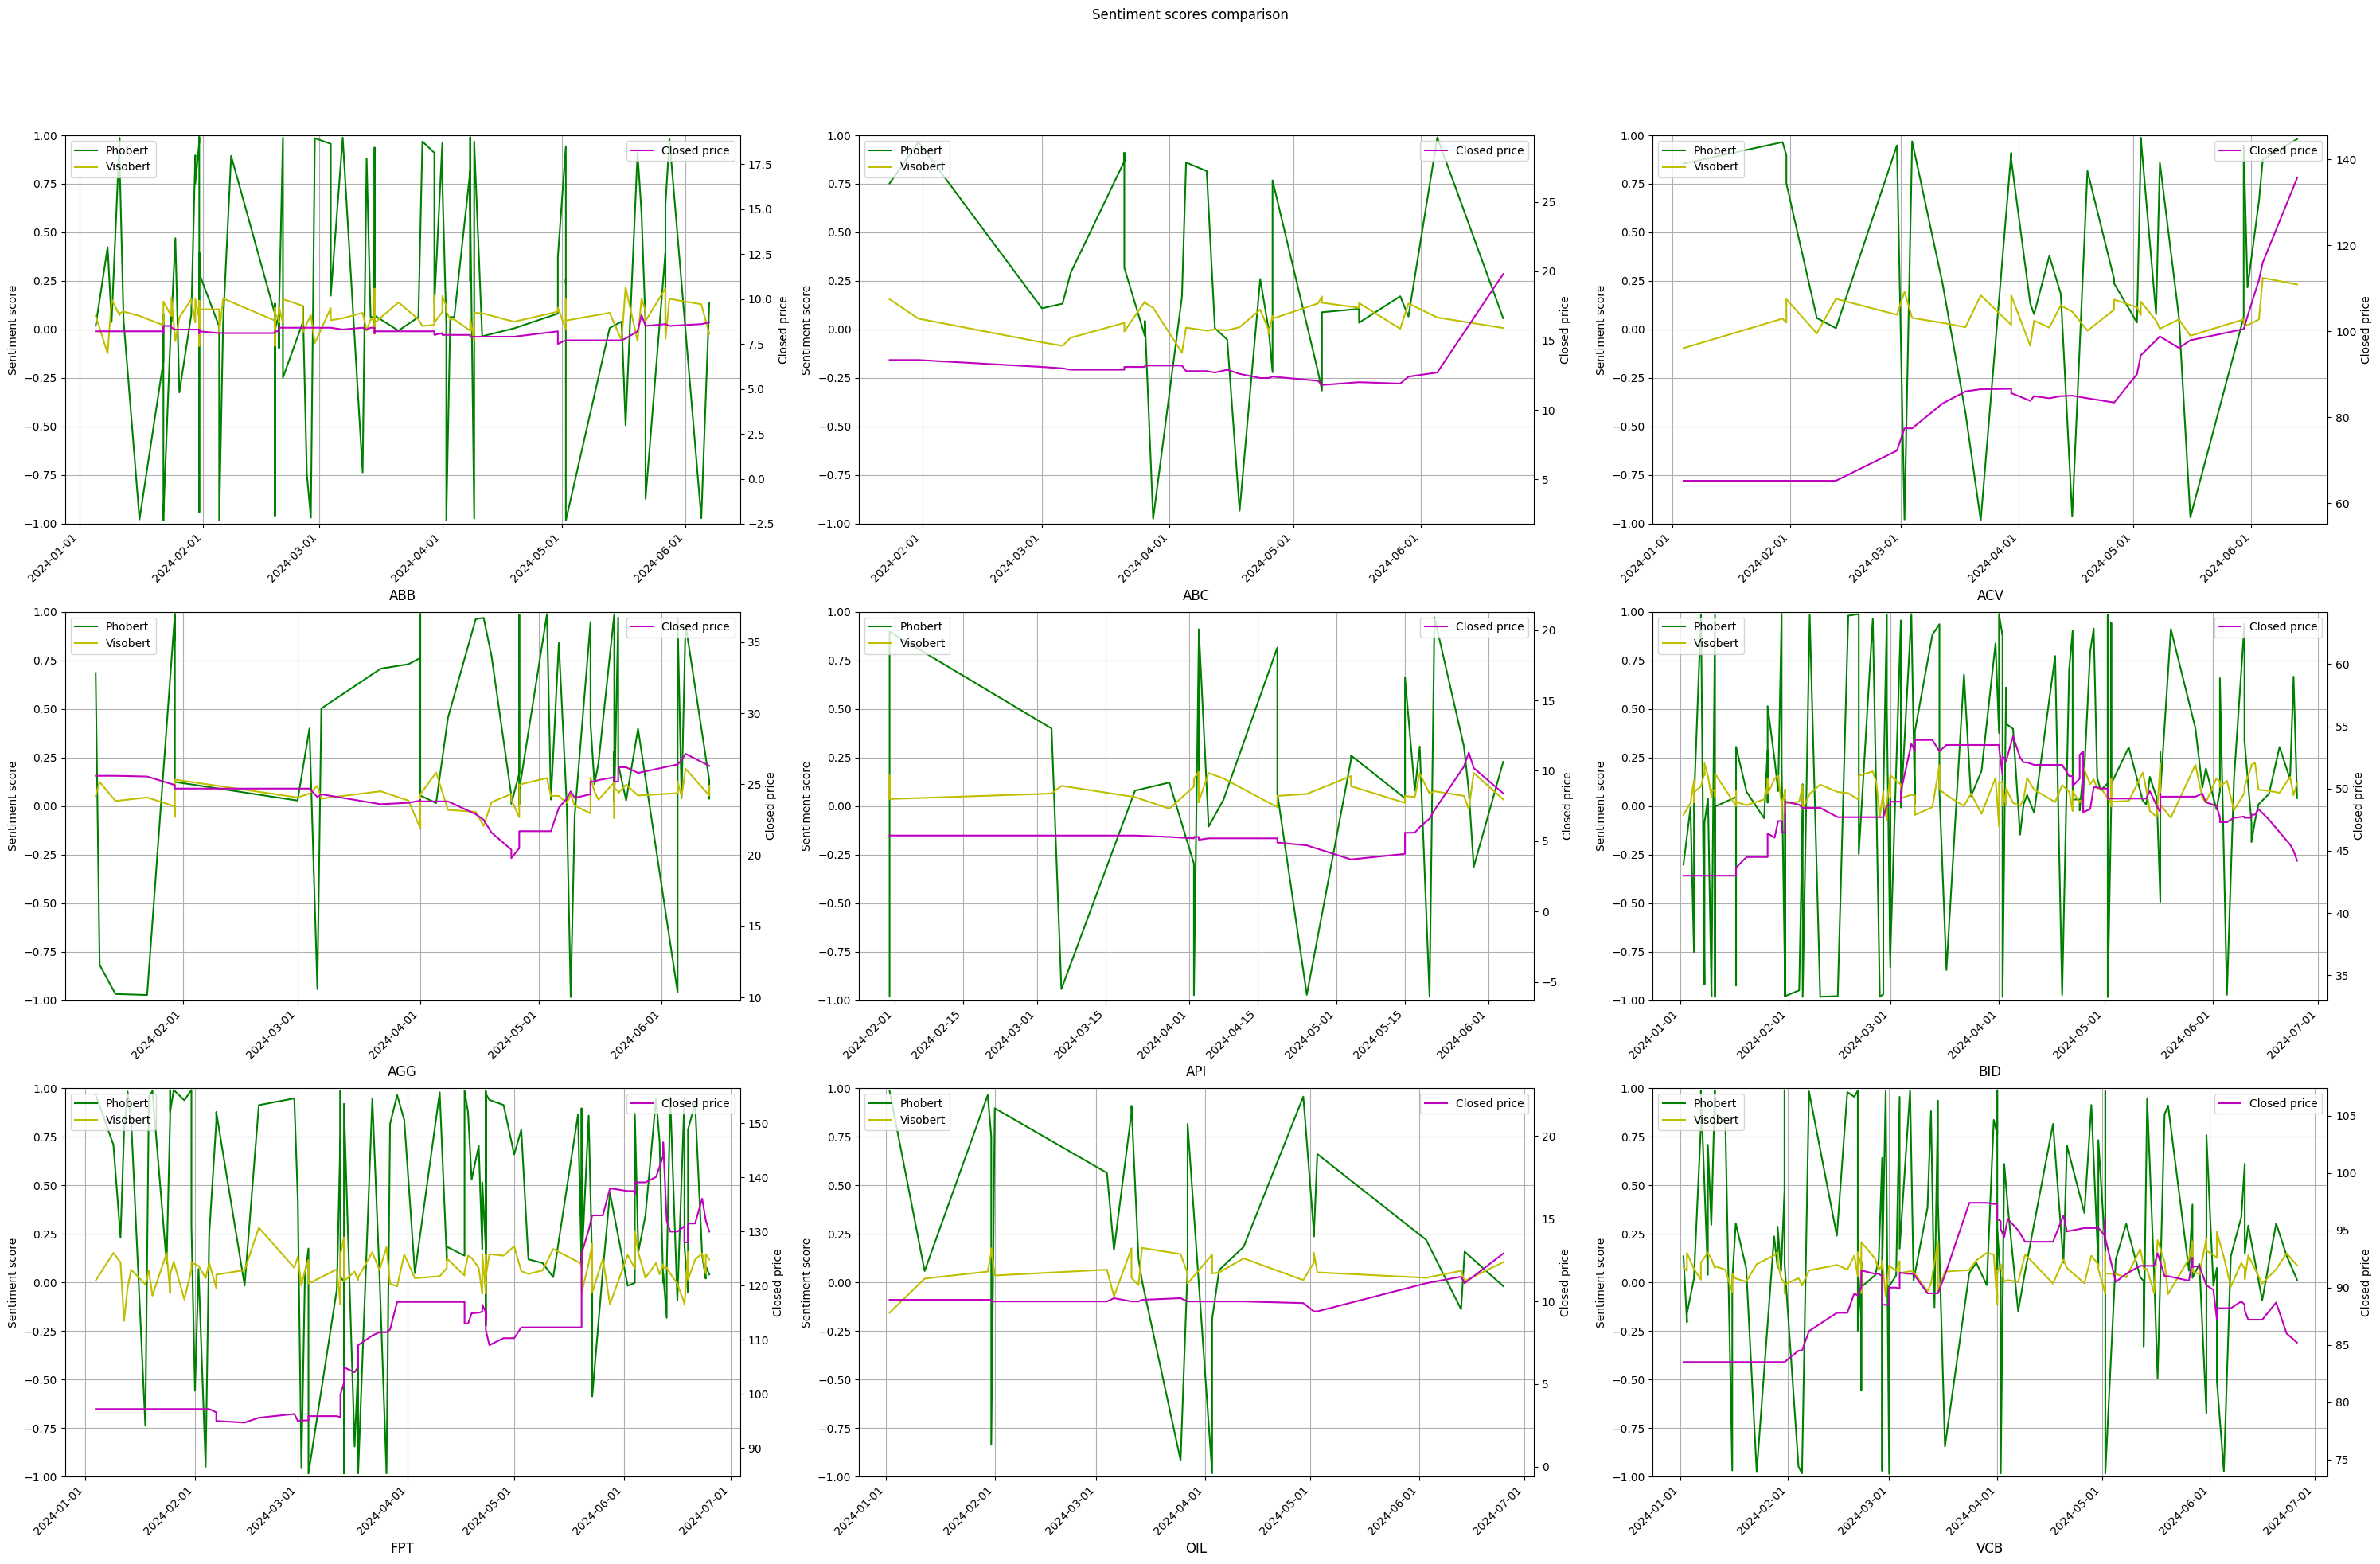

In [93]:
fig = plt.figure(figsize=(30, 20))

max_length = len(company_news[company_list[0]]['timeline'])

for idx, company in enumerate(company_list):
    date = date_time[idx]
    plot_index = idx + 1
    plot_col = 3
    plot_row = len(company_list) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)

    # ax.plot(dates, vader_sentiment_scores[idx], color='c', label='VADER')
    ax.plot(dates, phobert_sentiment_scores[idx], color='g', label='Phobert')
    ax.plot(dates, visobert_sentiment_scores[idx], color='y', label='Visobert')
    ax.legend(loc='upper left')
    ax.set_ylabel('Sentiment score')
    ax.set_xlabel(company, fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axt = ax.twinx()
    axt.plot(dates, stock_price[idx], color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylabel('Closed price')

    axt.set_ylim(min(stock_price[idx]) - 10, max(stock_price[idx]) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.suptitle('Sentiment scores comparison')
plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('compare_sentiment_scores.png')
plt.show()

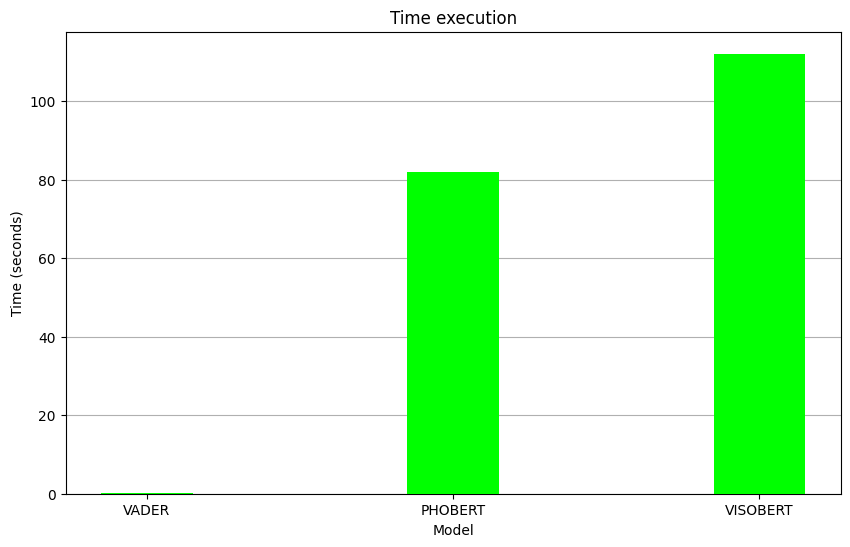

In [157]:
time_execution = {
    'VADER': vader_time_execution,
    'PHOBERT': phobert_time_execution,
    'VISOBERT': visobert_time_execution
 }

fig, ax = plt.subplots(figsize=(10, 6))
ax.yaxis.grid(zorder=0)
ax.bar(time_execution.keys(), time_execution.values(), color='lime', width=0.3, linewidth=2.5, zorder=3)
ax.set_title('Time execution')
ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
plt.savefig('compare_time_execution.png')
plt.show()

# Download file .png

In [158]:
download_choice = input("Do you want to download the files? (y/n): ")

if download_choice.lower() == 'y':
    for filename in os.listdir('/content'):
        if filename.endswith('.png'):
            files.download(filename)
else:
    print("Download canceled.")

Do you want to download the files? (y/n): n
Download canceled.
